# Distribution analysis

Analyze the distributions of genre labels

First define code for normalizing an array and drawing a confusion matrix

In [41]:
# source: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

%matplotlib notebook
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def computeRowTotals(array):
    rowTotals = []
    for i in range(0,len(array)): rowTotals.append(sum(array[i]))
    return(rowTotals)

def computeColumnTotals(array):
    columnTotals = []
    if len(array) > 0: 
        for i in range(0,len(array[0])): columnTotals.append(sum([x[i] for x in array]))
    return(columnTotals)
    
def normalizeArray(arrayIn):
    arrayOut = []
    for i in range(0,len(array)):
        arrayOut.append([])
        totalRow = sum(arrayIn[i])
        for j in range(0,len(arrayIn[i])): arrayOut[i].append(round(100*arrayIn[i][j]/totalRow))
    return(arrayOut)
            
def cm(array,columnNames):
    arrayNorm = normalizeArray(array)
    df_cm = pd.DataFrame(arrayNorm, index = columnNames, columns = columnNames)
    plt.figure(figsize = (8,3))
    sn.heatmap(df_cm, annot=True,cmap="Blues")

Additional code for changing the background color of a Jupyter notebook cell. Use as "%%bgc color"

In [2]:
# source https://stackoverflow.com/questions/49429585/
#        how-to-change-the-background-color-of-a-single-cell-in-a-jupyter-notebook-jupy

from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

@register_cell_magic
def bgc(color,cell=None): 
    script = ("var cell = this.closest('.code_cell');" 
              "var editor = cell.querySelector('.input_area');" 
              "editor.style.background='{}';" 
              "this.parentNode.removeChild(this)" ).format(color) 
    display(HTML('<img src onerror="{}">'.format(script)))

Next draw a confusion matrix for an analysis by FastText. The analysis was taken from the file 20190419.ipynb, heading "Error analysis", cell 2 (11cv training with 8331 articles, 9 labels, 20 epochs, with word vector dimension 300 and pretrained Wikipedia word vectors, accuracy=71.8%)

In [13]:
columnNames = ["NIE","SER","ACH","VER","REC","OPI","COL","INT","REP"]
columnNames = ["NEW","SER","BAC","REP","REV","OPE","COL","INT","FEA"]
array = [[3213,  104,  263,   69,   25,   12,    2,    9,    0 ],
          [322, 1327,   76,   51,   54,   32,   34,   12,    6 ],
          [412,   14,  745,   49,   21,   16,    6,   16,    2 ],
          [128,   20,   79,  243,    5,    5,    1,    1,    0 ],
           [12,    4,   32,    1,  246,    9,    2,    1,    0 ],
           [16,    1,   99,    0,   10,   74,   12,    3,    0 ],
            [7,   11,   36,    5,   11,   19,   81,    8,    6 ],
            [5,    4,   61,    1,    2,    3,    9,   47,    1 ],
            [2,    1,   75,    7,   11,    0,    9,    8,    5 ]]
sum(computeRowTotals(array))

8331

<IPython.core.display.Javascript object>


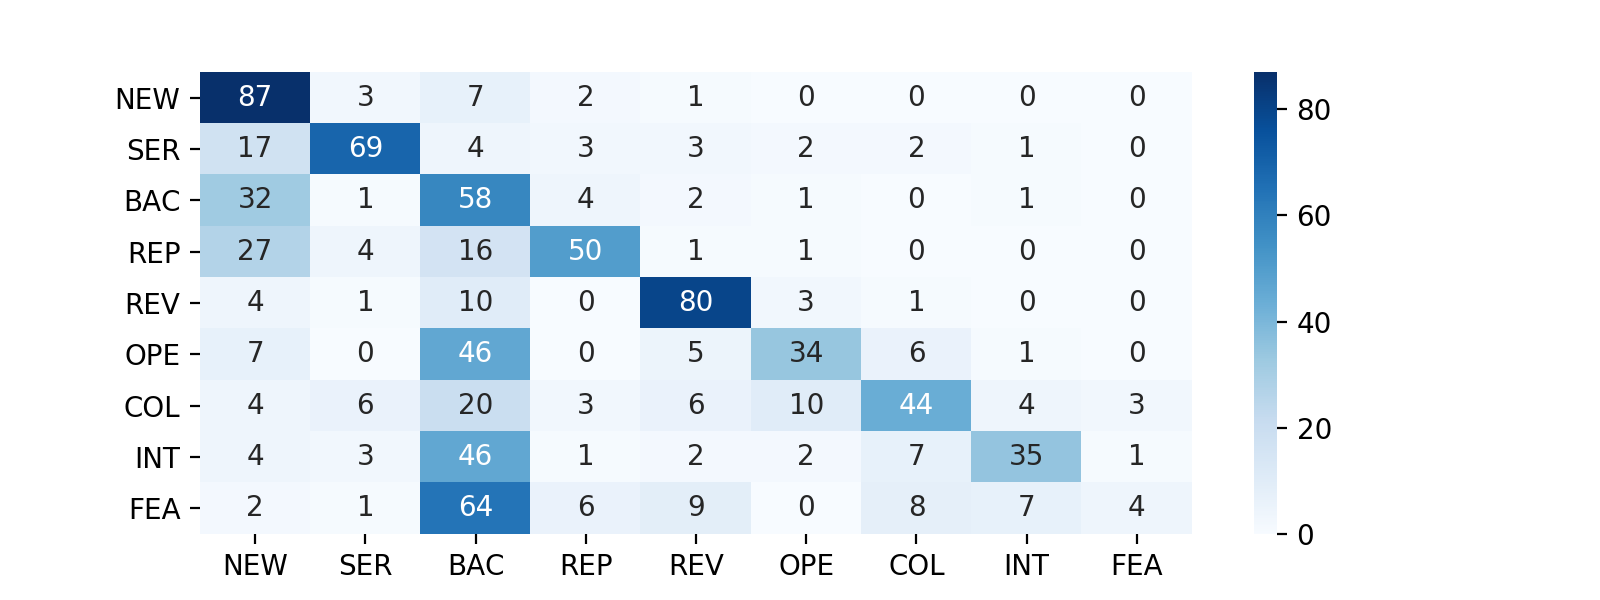

In [15]:
cm(array,columnNames)

**Swap labels**: put the labels together that are of the same class in the three-way split situation: NIE with INT, REP and VER, COL with ACH, OPI and REC, and SER by itself. The goal is to see if we can observe any confusion patterns within these groups.

In [16]:
def swapRows(arrayIn,col1,col2):
    arrayOut = []
    for col in range(0,len(arrayIn)):
        if col == col1: arrayOut.append(arrayIn[col2])
        elif col == col2: arrayOut.append(arrayIn[col1])
        else: arrayOut.append(arrayIn[col])
    return(arrayOut)

def swapColumns(arrayIn,col1,col2):
    arrayOut = []
    for col in range(0,len(arrayIn)):
        row = list(arrayIn[col])
        row[col1],row[col2] = row[col2],row[col1]
        arrayOut.append(row)
    return(arrayOut)

def swapRowsColumns(arrayIn,columnNamesIn,col1,col2):
    arrayTmp = swapRows(arrayIn,col1,col2)
    arrayOut = swapColumns(arrayTmp,col1,col2)
    columnNamesOut = swapRows(columnNamesIn,col1,col2)
    return(arrayOut,columnNamesOut)

def swapData(array,columnNames):
    array1,columnNames1 = swapRowsColumns(array,columnNames,1,7)   # SER <=> INT
    array2,columnNames2 = swapRowsColumns(array1,columnNames1,2,8) # ACH <=> REP
    array3,columnNames3 = swapRowsColumns(array2,columnNames2,4,6) # REC <=> COL
    array4,columnNames4 = swapRowsColumns(array3,columnNames3,5,8) # OPI <=> ACH
    array5,columnNames5 = swapRowsColumns(array4,columnNames4,6,8) # REC <=> OPI
    array6,columnNames6 = swapRowsColumns(array5,columnNames5,7,8) # SER <=> REC
    return(array6,columnNames6)

The previous confusion matrix with swapped columns and rows.

<IPython.core.display.Javascript object>


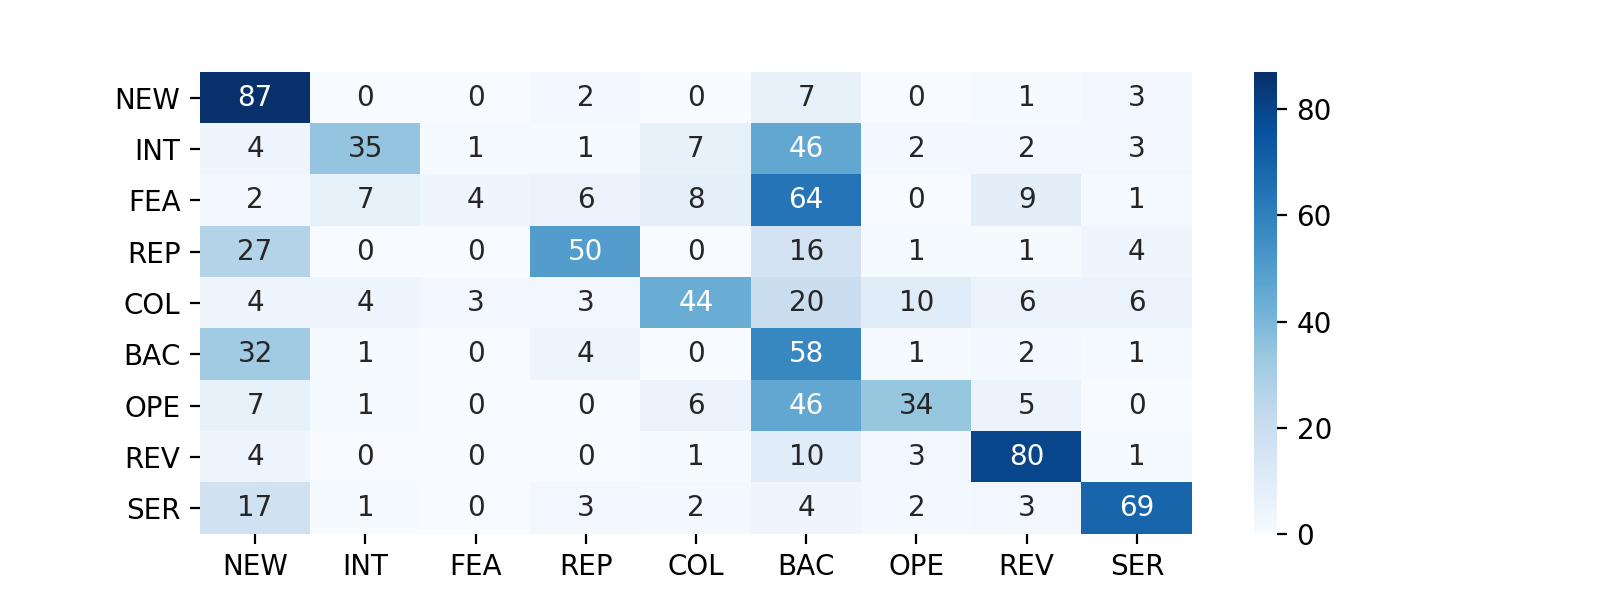

In [17]:
arraySwapped,columnNamesSwapped = swapData(array,columnNames)
cm(arraySwapped,columnNamesSwapped)

In [25]:
rowTotals = computeRowTotals(arraySwapped)
columnTotals = computeColumnTotals(arraySwapped)
predictionError = [100*(columnTotals[i]/rowTotals[i])-100 for i in range(0,len(rowTotals))]
print(rowTotals,"\n",columnTotals,"\n",predictionError)

[3697, 133, 118, 482, 184, 1281, 215, 307, 1914] 
 [4117, 105, 20, 426, 156, 1466, 170, 385, 1486] 
 [11.360562618339202, -21.05263157894737, -83.05084745762713, -11.61825726141079, -15.217391304347828, 14.441842310694767, -20.930232558139537, 25.407166123778495, -22.36154649947754]


In [45]:
# sorted column names:                                ACH COL INT NIE OPI REC REP SER VER
testDataTarget =    [345,37,19,28,39,129,32,73,213] # 129  39  37 345  32  73  19 213  28
testDataPredicted = [371,12, 3,19,23,184,29,64,210] # 184  23  12 371  29  64   3 210  19
predictionError0 = [100*(testDataPredicted[i]/testDataTarget[i])-100 for i in range(0,len(testDataTarget))]
print(sum(testDataTarget),sum(testDataPredicted))

testDataPredictedReestimated1 = [testDataPredicted[i]/(1.0+0.01*predictionError[i]) 
                                 for i in range(0,len(testDataPredicted))]
predictionError1 = [100*(testDataPredictedReestimated1[i]/testDataTarget[i])-100 for i in range(0,len(testDataTarget))]
print(predictionError0,"\n",predictionError1)
print("average:",sum([abs(x) for x in predictionError0])/len(predictionError0))
print("average:",sum([abs(x) for x in predictionError1])/len(predictionError1))
predictionError0np = np.array([abs(x) for x in predictionError0])
print(np.mean(predictionError0np),np.std(predictionError0np))
predictionError1np = np.array([abs(x) for x in predictionError1])
print(np.mean(predictionError1np),np.std(predictionError1np))

915 915
[7.536231884057969, -67.56756756756756, -84.21052631578948, -32.14285714285714, -41.02564102564102, 42.63565891472868, -9.375, -12.328767123287676, -1.408450704225345] 
 [-3.434187691192065, -58.91891891891892, -6.842105263157833, -23.222669349429907, -30.44049967126891, 24.63593388115106, 14.613970588235304, -30.090731186621582, 26.988038594961466]
average: 33.13674451979498
average: 24.35411723832634
33.13674451979498 27.094747213742295
24.35411723832634 15.319413663822084


In [46]:
testDataPredictedReestimated2 = reEstimate(testDataPredicted,arraySwapped)
predictionError2 = [100*(testDataPredictedReestimated2[i]/testDataTarget[i])-100 for i in range(0,len(testDataTarget))]
print(predictionError2)
print("average:",sum([abs(x) for x in predictionError2])/len(predictionError2))
predictionError2np = np.array([abs(x) for x in predictionError2])
print(np.mean(predictionError2np),np.std(predictionError2np))

[0.8253139267114591, -55.65070566184788, -21.75313786963426, 32.358100039194426, -33.9664837513687, 11.651622294781731, -4.978910756608386, -33.49921099304068, 17.40857633886617]
average: 23.565784625783742
23.565784625783742 16.191010962734712


A confusion matrix for the same model but build from text with removed quoted text (heading "Marking quoted text", cell 7)

In [47]:
columnNames = ["NIE","SER","ACH","VER","REC","OPI","COL","INT","REP"]
array = [[3186,  107,  278,   72,   29,   11,    2,   12,    0],
          [314, 1314,   79,   53,   53,   35,   44,   13,    9],
          [411,   14,  745,   50,   20,   13,    7,   19,    2],
          [118,   18,   92,  240,    5,    5,    2,    1,    1],
            [8,    6,   34,    1,  246,    8,    3,    1,    0],
           [15,    2,   90,    1,   10,   81,   15,    1,    0],
            [5,   10,   34,    8,   12,   20,   87,    4,    4],
            [5,    2,   61,    0,    1,    1,   16,   45,    2],
            [2,    1,   74,    6,   11,    0,   12,   10,    2]]
arraySwapped,columnNamesSwapped = swapData(array,columnNames)
sum(computeRowTotals(arraySwapped))

8331

<IPython.core.display.Javascript object>


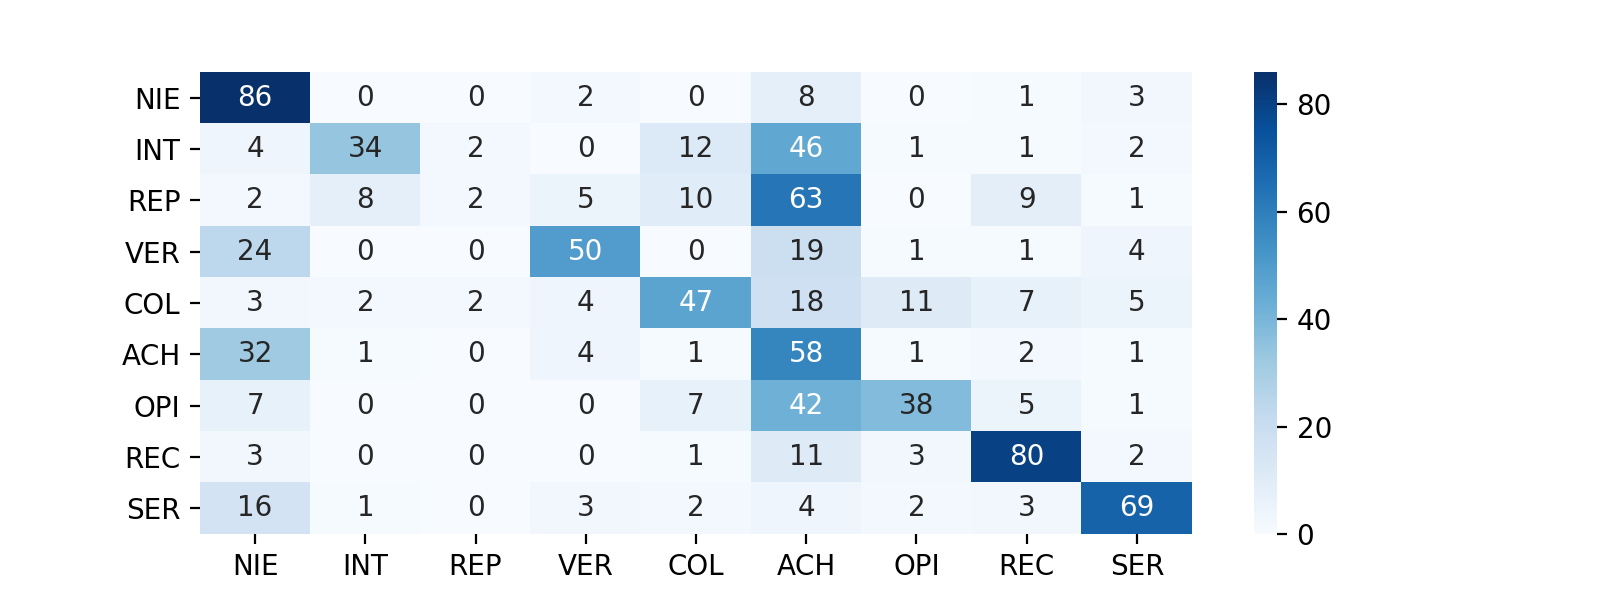

In [49]:
cm(arraySwapped,columnNamesSwapped)

The source of this data is unknown. The numbers are for all data (9,246 articles).

In [50]:
columnNames = ["ACH","COL","INT","NIE","OPI","REC","REP","SER","VER"]
array = [[796,   8,  17,  425,  21,  20,   1,   68,  54],
          [38,  72,   9,    5,  22,  13,   3,   58,   3],
          [78,  11,  56,    5,   3,   4,   1,   11,   1],
         [301,   2,   6, 3375,  11,  18,   1,  257,  71],
         [101,   8,   2,   15,  87,  12,   0,   22,   0],
          [28,   3,   0,    8,  10, 286,   1,   43,   1],
          [77,  11,  10,    2,   0,   7,  11,   14,   5],
          [82,  27,  12,  318,  32,  43,   3, 1563,  47],
          [84,   1,   0,  121,   3,   4,   0,   47, 250]]
arraySwapped,columnNamesSwapped = swapData(array,columnNames)
sum(computeRowTotals(arraySwapped))

9246

<IPython.core.display.Javascript object>


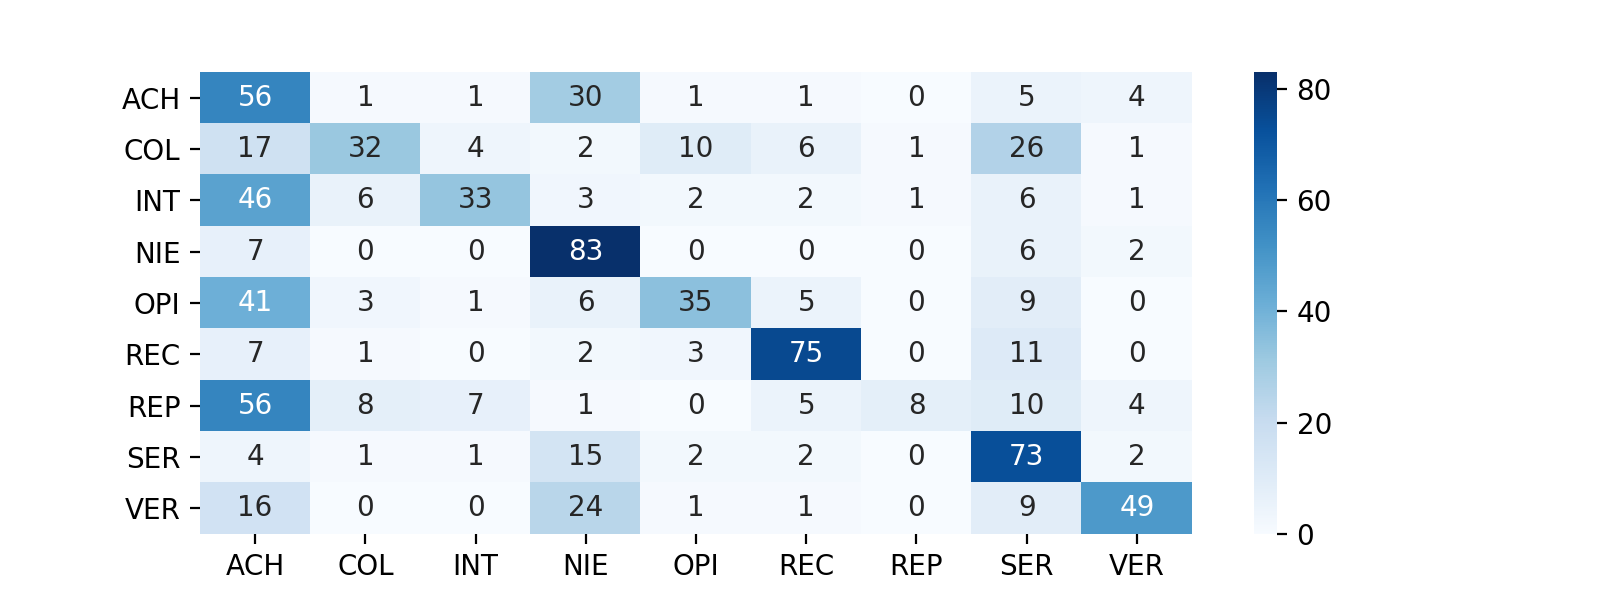

In [51]:
cm(array,columnNames)

## Re-estimation of label counts

The absolute sums of the rows give the true count of the labels while the absolute sum of the columns give the predicted counts. Note that the confusion matrices do not show absolute values but percentages. 

In [52]:
print("true distribution:     ",computeRowTotals(arraySwapped))
print("predicted distribution:",computeColumnTotals(arraySwapped))

true distribution:      [1410, 2127, 510, 4042, 137, 170, 380, 247, 223]
predicted distribution: [1585, 2083, 432, 4274, 21, 112, 407, 189, 143]


The confusion matrix contains information on how the machine learner has converted the true label distribution to the predicted label distribution. We can design a mathematical inverse of this operation. As a test, we apply it to the output of the machine learner for the training data. The result should be exactly the same as the true label distribution, which proves to be the case.

In [53]:
def reEstimate(scoreList,confusionMatrix):
    reEstimatedScoreList = []
    columnTotals = computeColumnTotals(confusionMatrix) 
    for i in range(0,len(scoreList)):
        total = 0.0
        for column in range(0,len(scoreList)):
            total += scoreList[column]*confusionMatrix[i][column]/columnTotals[column]
        reEstimatedScoreList.append(total)
    return(reEstimatedScoreList)

print("re-estimated predicted distribution:",reEstimate(computeColumnTotals(arraySwapped),arraySwapped))

re-estimated predicted distribution: [1410.0, 2127.0, 510.0, 4042.0, 137.0, 170.0, 380.0, 247.0, 223.0]


The source of this data is unknown. This data set contains 8,508 articles.

In [54]:
# first section with -w
columnNames = ["ACH","COL","INT","NIE","OPI","REC","REP","SER","VER"]
array = [[  773,   10,   17,  433,   15,   15,    2,   63,   47],
 [   34,   71,   10,    5,   21,   14,    2,   51,    4],
 [   77,   12,   53,    4,    3,    4,    1,    9,    1],
 [  294,    2,    6, 3091,    8,   18,    0,  231,   60],
 [  101,    9,    2,   12,   77,   12,    0,   20,    0],
 [   28,    1,    0,    6,   10,  242,    1,   44,    0],
 [   72,   11,    9,    3,    0,    8,    8,   12,    4],
 [   76,   22,   11,  271,   28,   39,    3, 1418,   41],
 [   82,    1,    0,  118,    5,    3,    0,   34,  203]]
sum(computeRowTotals(array))

8508

<IPython.core.display.Javascript object>


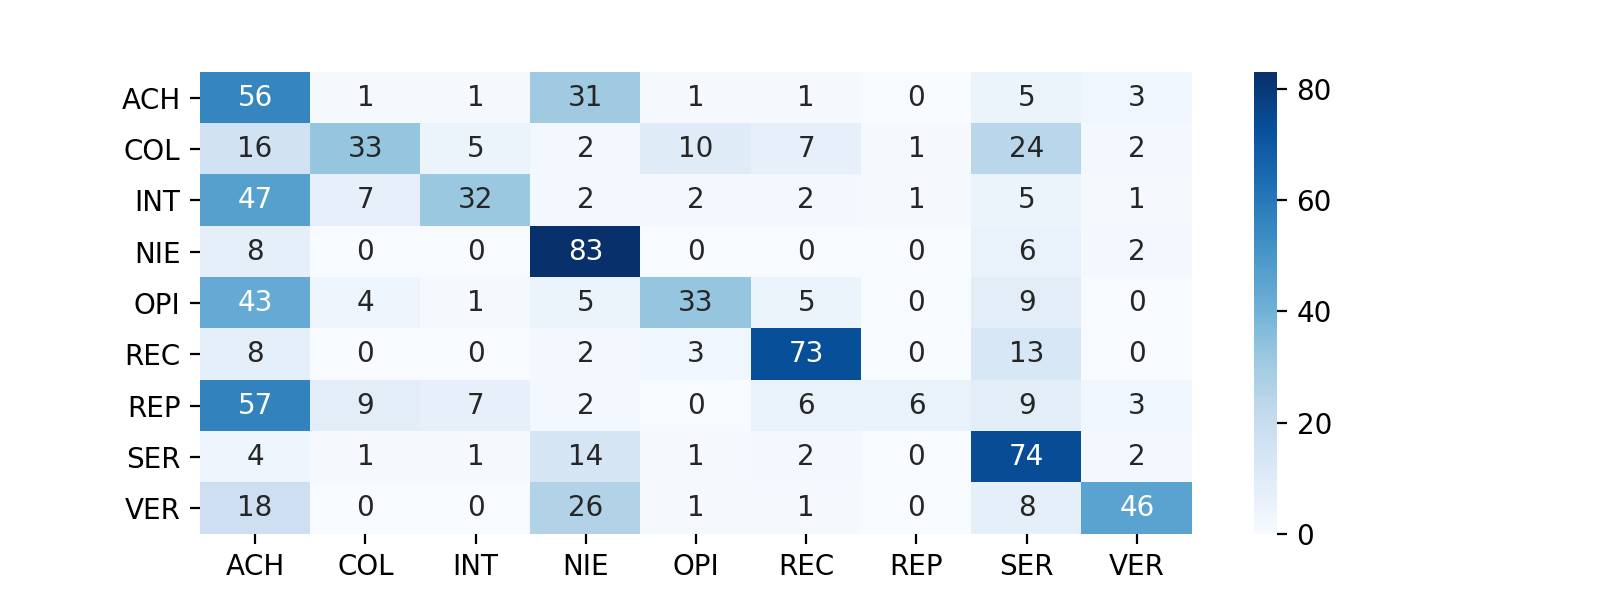

In [55]:
cm(array,columnNames)

In [56]:
predictions = [83,1,0,361,0,46,0,234,13]
print(reEstimate(predictions,array))
# correct: 35 11 6 332 14 48 10 218 64

[92.93215381516347, 11.104264290719032, 6.284093032655208, 332.10683982841596, 10.659181308858557, 38.89708085144874, 6.914988259436183, 211.91594292620977, 27.18545568709312]


In [64]:
import os
import re
import sys

DATADIR = "/home/erikt/projects/newsgac/data-large/telegraaf.cwi"
FILENAMEPREFIX = "TRAIN."
FILENAMESUFFIX = ".labels"
EXPERIMENTS = [str(x) for x in list(range(0,10))+['A','B']]
TRAIN = "TRAIN"
TEST = "TRAIN.20191004:14:29:50.labels"

def getFileSizes():
    fileSizes = {}
    for experiment in EXPERIMENTS:
        inFileName = FILENAMEPREFIX+experiment+FILENAMESUFFIX
        inFile = open(inFileName,"r")
        lineCount = 0
        for line in inFile: lineCount += 1
        inFile.close()
        fileSizes[experiment] = lineCount
    return(fileSizes)

def getLabels(inFileName):
    labels = []
    inFile = open(inFileName,"r")
    for line in inFile:
        label = re.sub("\s.*$","",line)
        labels.append(label)
    inFile.close()
    return(labels)

def makeConfusionMatrix(experiment1):
    index = 0
    confusionMatrix = {}
    predictions = []
    goldLabelsOut = []
    for experiment2 in EXPERIMENTS:
        if experiment2 != experiment1:
            inFileName = FILENAMEPREFIX+experiment2+"."+experiment1+FILENAMESUFFIX
            inFile = open(inFileName,"r")
            for line in inFile:
                predictedLabel = re.sub("\s.*$","",line)
                goldLabel = goldLabels[index]
                if not goldLabel in confusionMatrix: confusionMatrix[goldLabel] = {}
                if not predictedLabel in confusionMatrix[goldLabel]: 
                    confusionMatrix[goldLabel][predictedLabel] = 0
                confusionMatrix[goldLabel][predictedLabel] += 1
                index += 1
            inFile.close()
        else:
            inFileName = FILENAMEPREFIX+experiment1+FILENAMESUFFIX
            inFile = open(inFileName,"r")
            for line in inFile:
                predictedLabel = re.sub("\s.*$","",line)
                predictions.append(predictedLabel)
                goldLabelsOut.append(goldLabels[index])
                index += 1
            inFile.close()
    return(confusionMatrix,predictions,goldLabelsOut)

def computeMixtures(confusionMatrix):
    mixtures = {}
    for predictedLabel in confusionMatrix:
        for goldLabel in confusionMatrix:
            if not predictedLabel in confusionMatrix[goldLabel]:
                confusionMatrix[goldLabel][predictedLabel] = 0
        totalColumn = sum([confusionMatrix[goldLabel][predictedLabel] for goldLabel in confusionMatrix])
        mixtures[predictedLabel] = {goldLabel:confusionMatrix[goldLabel][predictedLabel]/totalColumn \
                                   for goldLabel in confusionMatrix}
    return(mixtures)

def getMixtureAnalysis():
    mixtureAnalysis = []
    for experiment1 in EXPERIMENTS:
        confusionMatrix,predictions,goldLabelsOut = makeConfusionMatrix(experiment1)
        mixtures = computeMixtures(confusionMatrix)
        for prediction in predictions:
            mixtureAnalysis.append(mixtures[prediction])
    return(mixtureAnalysis)

def computeAccuracies(goldLabels,predictedLabels,mixtureAnalysis):
    correct = 0.0
    correctMixtures = 0.0
    for i in range(0,len(goldLabels)):
        correctMixtures += mixtureAnalysis[i][goldLabels[i]]
        if goldLabels[i] == predictedLabels[i]: correct += 1
    return(100*correct/len(goldLabels),100*correctMixtures/len(goldLabels))

def computePredictedCounts(goldLabels,predictedLabels,mixtureAnalysis):
    goldCounts = {}
    predictedCounts = {}
    predictedCountsMixtures = {}
    for i in range(0,len(goldLabels)):
        if not predictedLabels[i] in predictedCounts: predictedCounts[predictedLabels[i]] = 0
        predictedCounts[predictedLabels[i]] += 1
        for label in mixtureAnalysis[i]:
            if not label in predictedCountsMixtures: predictedCountsMixtures[label] = 0
            predictedCountsMixtures[label] += mixtureAnalysis[i][label]
        if not goldLabels[i] in goldCounts: goldCounts[goldLabels[i]] = 0
        goldCounts[goldLabels[i]] += 1
    return(goldCounts,predictedCounts,predictedCountsMixtures)

def printCounts(goldCounts,predictedCounts):
    totalDeviance = 0.0
    counts = 0
    for label in sorted(predictedCounts.keys()): 
        deviance = int(0.5+abs((goldCounts[label]-predictedCounts[label])))
        if predictedCounts[label] < goldCounts[label]: direction = "-"
        else: direction = "+"
        print("{} {} ({} {}{}%)".format(label,int(0.5+predictedCounts[label]),\
                                        deviance,direction,int(0.5+100*deviance/goldCounts[label])))
        counts += 1
        totalDeviance += int(0.5+100*deviance/goldCounts[label])
    print("Average deviance: {}%\n".format(int(0.5+totalDeviance/counts),"%"))
    
os.chdir(DATADIR)
fileSizes = getFileSizes()
goldLabels = getLabels(TRAIN)
predictedLabels = getLabels(TEST)
mixtureAnalysis = getMixtureAnalysis()
accuracy,accuracyMixtures = computeAccuracies(goldLabels,predictedLabels,mixtureAnalysis)
goldCounts,predictedCounts,predictedCountsMixtures = computePredictedCounts(goldLabels,predictedLabels,mixtureAnalysis)

print(accuracy,accuracyMixtures)
printCounts(goldCounts,predictedCounts)
printCounts(goldCounts,predictedCountsMixtures)
for label in sorted(goldCounts.keys()): print(label,goldCounts[label])

70.33311702357776 53.28329547448033
__label__ACH 1543 (133 +9%)
__label__COL 147 (76 -34%)
__label__INT 116 (54 -32%)
__label__NIE 4316 (274 +7%)
__label__OPI 188 (59 -24%)
__label__REC 407 (27 +7%)
__label__REP 20 (117 -85%)
__label__SER 2084 (43 -2%)
__label__VER 425 (85 -17%)
Average deviance: 24%

__label__ACH 1399 (11 -1%)
__label__COL 228 (5 +2%)
__label__INT 168 (2 -1%)
__label__NIE 4050 (8 +0%)
__label__OPI 248 (1 +0%)
__label__REC 377 (3 -1%)
__label__REP 138 (1 +1%)
__label__SER 2129 (2 +0%)
__label__VER 507 (3 -1%)
Average deviance: 1%

__label__ACH 1410
__label__COL 223
__label__INT 170
__label__NIE 4042
__label__OPI 247
__label__REC 380
__label__REP 137
__label__SER 2127
__label__VER 510


In [65]:
sum([goldCounts[x] for x in goldCounts])

9246

In [66]:
NEWSPAPERFILE="TRAIN.newspapers"
NEWSPAPERLIST=["05NRC_Handelsblad","06De_Telegraaf","08De_Volkskrant"]

newspapers = []
inFile = open(NEWSPAPERFILE,"r")
for line in inFile: newspapers.append(line.strip())
inFile.close()
goldCountsAll,forget1,forget2 = computePredictedCounts(goldLabels,predictedLabels,mixtureAnalysis)
goldCountsAllTotal = sum(list(goldCountsAll.values()))
for newspaper in NEWSPAPERLIST:
    glN = [goldLabels[i] for i in range(0,len(newspapers)) if newspapers[i] == newspaper]
    plN = [predictedLabels[i] for i in range(0,len(newspapers)) if newspapers[i] == newspaper]
    maN = [mixtureAnalysis[i] for i in range(0,len(newspapers)) if newspapers[i] == newspaper]
    goldCounts,predictedCounts,predictedCountsMixtures = computePredictedCounts(glN,plN,maN)
    print("predictedCounts",newspaper)
    printCounts(goldCounts,predictedCounts)
    predictedCountsTotal = sum(list(predictedCounts.values()))
    baselineCounts = {x:int(0.5+goldCountsAll[x]*predictedCountsTotal/goldCountsAllTotal) for x in goldCountsAll}
    print("baselineCounts",newspaper)
    printCounts(goldCounts,baselineCounts)
    print("predictedCountsMixtures",newspaper)
    printCounts(goldCounts,predictedCountsMixtures)
    print("goldCounts",newspaper)
    for label in sorted(goldCounts.keys()): print(label,goldCounts[label])
    print()

predictedCounts 05NRC_Handelsblad
__label__ACH 559 (83 +17%)
__label__COL 51 (16 -24%)
__label__INT 22 (22 -50%)
__label__NIE 1338 (98 +8%)
__label__OPI 92 (25 -21%)
__label__REC 183 (33 +22%)
__label__REP 10 (52 -84%)
__label__SER 587 (76 -11%)
__label__VER 88 (23 -21%)
Average deviance: 29%

baselineCounts 05NRC_Handelsblad
__label__ACH 447 (29 -6%)
__label__COL 71 (4 +6%)
__label__INT 54 (10 +23%)
__label__NIE 1281 (41 +3%)
__label__OPI 78 (39 -33%)
__label__REC 120 (30 -20%)
__label__REP 43 (19 -31%)
__label__SER 674 (11 +2%)
__label__VER 162 (51 +46%)
Average deviance: 19%

predictedCountsMixtures 05NRC_Handelsblad
__label__ACH 471 (5 -1%)
__label__COL 79 (12 +18%)
__label__INT 51 (7 +16%)
__label__NIE 1259 (19 +2%)
__label__OPI 99 (18 -15%)
__label__REC 159 (9 +6%)
__label__REP 47 (15 -24%)
__label__SER 627 (36 -5%)
__label__VER 137 (26 +23%)
Average deviance: 12%

goldCounts 05NRC_Handelsblad
__label__ACH 476
__label__COL 67
__label__INT 44
__label__NIE 1240
__label__OPI 117
__l

In [59]:
# antonio bella et al 2010 (applies to binary targets)

def getMixtureAnalysis():
    mixtureAnalysis = {}
    for experiment1 in EXPERIMENTS:
        confusionMatrix,predictions,goldLabels = makeConfusionMatrix(experiment1)
        mixtures = computeMixtures(confusionMatrix)
        mixtureAnalysis[experiment1] = {"size":0}
        for key in mixtures: 
            mixtureAnalysis[experiment1][key] = {"predicted":0.0,"estimated":0,"ppapCount":0.0,"ppanCount":0.0}
        for prediction in predictions:
            mixtureAnalysis[experiment1]["size"] += 1
            mixtureAnalysis[experiment1][prediction]["predicted"] += 1
            for key in mixtures[prediction]: 
                mixtureAnalysis[experiment1][key]["estimated"] += mixtures[prediction][key]
        for key1 in confusionMatrix:
            totalRow = sum([confusionMatrix[key1][key2] for key2 in confusionMatrix])
            mixtureAnalysis[experiment1][key1]["ppapCount"] = confusionMatrix[key1][key1]/totalRow
            totalMatrix = sum([sum(confusionMatrix[key2].values()) for key2 in confusionMatrix if key2 != key1])
            totalColumn = sum([confusionMatrix[key2][key1] for key2 in confusionMatrix if key2 != key1])
            mixtureAnalysis[experiment1][key1]["ppanCount"] = totalColumn/totalMatrix
    return(mixtureAnalysis)

os.chdir(DATADIR)
fileSizes = getFileSizes()
goldLabels = getLabels(TRAIN)
predictedLabels = getLabels(TEST)
mixtureAnalysis = getMixtureAnalysis()
counts = { label:0.0 for label in mixtureAnalysis['0'] if label != "size" }
for experiment in mixtureAnalysis:
    for label in mixtureAnalysis[experiment]: 
        if label != "size":
            counts[label] += (mixtureAnalysis[experiment][label]["estimated"]/ \
                              mixtureAnalysis[experiment]["size"]- \
                              mixtureAnalysis[experiment][label]["ppanCount"])/ \
                             (mixtureAnalysis[experiment][label]["ppapCount"]- \
                              mixtureAnalysis[experiment][label]["ppanCount"])
for key in counts: counts[key] *= len(goldLabels)/len(mixtureAnalysis)
counts

{'__label__NIE': 3697.3488788871277,
 '__label__SER': 2204.525519357469,
 '__label__REC': 327.4791855965124,
 '__label__COL': 505.2439241106192,
 '__label__ACH': 1022.7226262539583,
 '__label__INT': 346.49381620263347,
 '__label__REP': 4293.643770580325,
 '__label__OPI': 428.35570802055634,
 '__label__VER': 684.3394058657811}